In [1]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

# set random seed for comparing the two result calculations
tf.set_random_seed(1)

In [2]:
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data\train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [3]:
type(mnist)

tensorflow.contrib.learn.python.learn.datasets.base.Datasets

In [4]:

mnist.train.images.shape

(55000, 784)

In [5]:

mnist.test.images.shape

(10000, 784)

In [6]:

mnist.train.labels[8].argmax()

9

In [7]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (8,7)
%matplotlib inline

def draw_digit(x):
    img = x.reshape(28,28)
    plt.imshow(img, cmap='gray', interpolation='none')

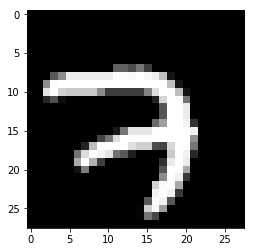

In [8]:
digit = mnist.train.images[0]
draw_digit(digit)

In [9]:
def draw_digits(digits, labels, n_rows=3):
    n = len(digits)
    n_cols = int(n / n_rows)
    for i in range(0, n):
        plt.subplot(n_rows, n_cols, i+1)
        img = digits[i].reshape(28,28)
        label = labels[i].argmax()
        plt.imshow(img, cmap='gray', interpolation='none')
        plt.title(label, fontsize=12)
        plt.tick_params(axis='both', which='major', labelsize=6)
        plt.subplots_adjust(hspace=0.0, wspace=0.5)

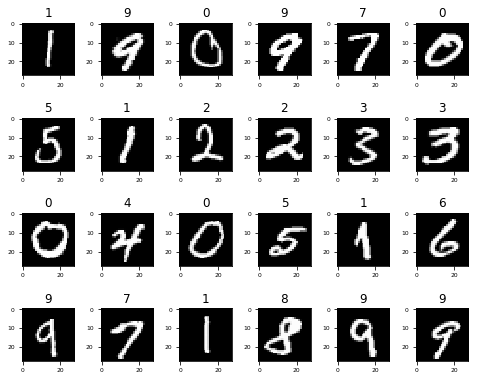

In [10]:
plt.rcParams['figure.figsize'] = (8,7)
digits = mnist.train.images[500:524]
labels = mnist.train.labels[500:524]
draw_digits(digits, labels, n_rows=4)

In [11]:

lr = 0.001                   # learning rate
training_iters = 100000      # Number of training 
batch_size = 128             # Batch size
n_inputs = 28                # MNIST data input (img shape: 28*28)
n_steps = 28                 # Time steps for recurrent cell
n_hidden_units = 128         # Number of neurons in hidden layer
n_classes = 10               # MNIST classes (0-9 digits): 0, 1, 2, 3, ..., 9

In [12]:
# tf Graph inputs
x = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_classes])

# Define weights matrices
weights = {
    # matrix from inputs (28) to hidden layer (128). shape is: (28, 128)
    'in': tf.Variable(tf.random_normal([n_inputs, n_hidden_units])),
    # matrix from hidden layer to output layer, shape is: (128, 10)
    'out': tf.Variable(tf.random_normal([n_hidden_units, n_classes]))
}

# Define bias vectors
biases = {
    # bias for the input to hidden layer (128, )
    'in': tf.Variable(tf.constant(0.1, shape=[n_hidden_units, ])),
    # bias from the hidden to putput layer (10, )
    'out': tf.Variable(tf.constant(0.1, shape=[n_classes, ]))
}

In [13]:
def RNN(X, weights, biases):
    # hidden layer for input to lstm cell

    # transpose the inputs shape from 3D [batch, steps, inputs]
    # to 2D: [(128 batch * 28 steps), 28 inputs)
    # new shape: [128*28, 28]
    X = tf.reshape(X, [-1, n_inputs])

    # flow from input layer to hidden layer
    # X_in = (128 batch * 28 steps, 128 hidden)
    X_in = tf.matmul(X, weights['in']) + biases['in']
    # X_in ==> (128 batch, 28 steps, 128 hidden)
    X_in = tf.reshape(X_in, [-1, n_steps, n_hidden_units])

    # basic LSTM Cell
    lstm_cell = tf.nn.rnn_cell.BasicLSTMCell(n_hidden_units, forget_bias=1.0, state_is_tuple=True)
    # lstm cell is divided into two parts (c_state, h_state)
    init_state = lstm_cell.zero_state(batch_size, dtype=tf.float32)

    # You have 2 options for following step.
    # 1: tf.nn.rnn(cell, inputs);
    # 2: tf.nn.dynamic_rnn(cell, inputs).
    # In option 1, you have to modify the shape of X_in, go and check out this:
    # https://github.com/aymericdamien/TensorFlow-Examples/blob/master/examples/3_NeuralNetworks/recurrent_network.py
    # Here, we go for option 2:
    # dynamic_rnn receive Tensor (batch, steps, inputs) or (steps, batch, inputs) as X_in.
    # Make sure the time_major is changed accordingly.
    outputs, final_state = tf.nn.dynamic_rnn(lstm_cell, X_in, initial_state=init_state, time_major=False)

    # hidden layer for output as the final results:
    # results = tf.matmul(final_state[1], weights['out']) + biases['out']
    # or:
    # unpack to list [(batch, outputs)..] * steps
    outputs = tf.unstack(tf.transpose(outputs, [1, 0, 2]))    # states is the last outputs
    results = tf.matmul(outputs[-1], weights['out']) + biases['out']

    return results

In [14]:
pred = RNN(x, weights, biases)
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=y, logits=pred))
train_op = tf.train.AdamOptimizer(lr).minimize(cost)

In [15]:

correct_pred = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

In [16]:
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)
step = 0
while step * batch_size < training_iters:
    batch_xs, batch_ys = mnist.train.next_batch(batch_size)
    batch_xs = batch_xs.reshape([batch_size, n_steps, n_inputs])
    inp = {x: batch_xs, y: batch_ys}
    sess.run([train_op], feed_dict=inp)
    if step % 20 == 0:
        inp = {x: batch_xs, y: batch_ys}
        print(sess.run(accuracy, feed_dict=inp))
    step += 1

0.265625
0.7265625
0.828125
0.8828125
0.84375
0.859375
0.8984375
0.890625
0.84375
0.90625
0.921875
0.90625
0.9140625
0.9140625
0.9375
0.9609375
0.953125
0.921875
0.9453125
0.96875
0.9375
0.9609375
0.890625
0.984375
0.953125
0.953125
0.9453125
0.9453125
0.96875
0.9375
0.953125
0.96875
0.9375
0.9921875
0.9609375
0.9609375
0.953125
0.9609375
0.96875
0.96875


In [19]:
import numpy as np

def predict_classes(sess, digits):
    n_digits = len(digits)
    xbatches = digits.reshape([-1, batch_size, n_steps, n_inputs])
    n_batches = xbatches.shape[0]
    y_pred = []
    for i in range(n_batches):
        inp = {x: xbatches[i]}
        #y_pred = pred.eval(feed_dict=inp, session=sess)
        y_pred.extend(sess.run(pred, feed_dict=inp))
    return np.array(y_pred)

In [20]:
digits = mnist.test.images[0:128]
y_pred = predict_classes(sess, digits)
print(y_pred[0:5])

[[-2.263169    2.1794078   0.42790514  5.0582848   1.2745659   0.38527974
  -4.644747   17.128643   -2.8363147   2.1751153 ]
 [-2.6655705  -0.5135616  11.88025    -0.45332262  1.0152701  -1.7611496
   1.2334719   2.7878954  -1.9461758  -5.7347975 ]
 [-3.407368   12.024347   -2.3019786  -0.7994183   3.990151    1.0511202
  -0.95952135  5.8423233  -2.2201986  -0.6189654 ]
 [ 7.6883283  -5.9431057   1.3318704  -1.0456955  -3.2112184   2.0926368
   4.345531   -4.7442656   2.6322622   1.5901201 ]
 [ 1.1404055  -2.3757398  -6.5576887  -3.6273487   9.851462    1.3152143
   2.5863633   2.711026   -2.8736317   2.7648556 ]]


In [21]:
print([e.argmax() for e in y_pred[0:10]])

[7, 2, 1, 0, 4, 1, 4, 9, 5, 9]


In [22]:
print([label.argmax() for label in mnist.test.labels[0:10]])

[7, 2, 1, 0, 4, 1, 4, 9, 5, 9]


In [23]:
y_pred = predict_classes(sess, mnist.test.images[0:9984])
missed = []
for i,dig in enumerate(mnist.test.images[0:9984]):
    true_label = mnist.test.labels[i].argmax()
    pred_label = y_pred[i].argmax()
    if not true_label == pred_label:
        missed.append(i)

print("Network missed %d samples" % (len(missed)))
print("Validation accuracy: %.5f" % ((9984-len(missed))/9984.0))

Network missed 427 samples
Validation accuracy: 0.95723


In [24]:
print(missed[0:24])

[18, 20, 62, 92, 95, 151, 177, 184, 232, 247, 259, 266, 313, 321, 340, 359, 394, 412, 434, 435, 445, 448, 449, 464]


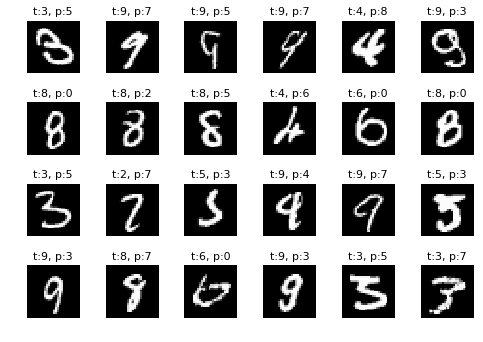

In [25]:
plt.rcParams['figure.figsize'] = (8,6)
for i in range(0, 24):
    plt.subplot(4, 6, i+1)
    img = mnist.test.images[missed[i]].reshape(28,28)
    true_label = mnist.test.labels[missed[i]].argmax()
    pred_label = y_pred[missed[i]].argmax()
    plt.imshow(img, cmap='gray', interpolation='none')
    title = "t:%s, p:%s" % (true_label, pred_label)
    plt.title(title, fontsize=11)
    plt.subplots_adjust(hspace=0.0, wspace=0.5)
    plt.axis('off')